In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE 
import numpy as np 

In [3]:
df = pd.read_csv(r'/work/modellingData.csv')  

In [4]:
df.dtypes  

Unnamed: 0            int64
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [5]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)  

In [6]:
df.drop(columns = ['Unnamed: 0', 'customerID', 'TotalCharges' ], inplace = True) 

In [7]:
df['Churn'].value_counts() 

No     5163
Yes    1869
Name: Churn, dtype: int64

Class Imbalance present



- Oversampling

- Undersampling

- Stratify while splitting

- Using Precision as metric

These are the various options which I will try individually and report the best result.

In [8]:
X = df.drop(columns = ['Churn'])
y = df['Churn'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Final data prep (i.e using one hot encoding)
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first= True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first= True)  


#Converting int of columns to categorical to ensure value doesnt count i.e not ordinal 
for col in X_train_encoded.columns:
    if X_train_encoded[col].dtype == 'uint8':
        X_train_encoded[col] = X_train_encoded[col].astype('object')

for col in X_test_encoded.columns:
    if X_test_encoded[col].dtype == 'uint8':
        X_test_encoded[col] = X_test_encoded[col].astype('object')

rf_classifier = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],       # Number of trees in the forest
    'max_depth': [None, 10, 20],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
best_rf_classifier = grid_search.best_estimator_


y_pred =  best_rf_classifier.predict(X_train_encoded)
precision = precision_score(y_train, y_pred, pos_label="Yes") 
accuracy = accuracy_score(y_train, y_pred) 

print("Best Hyperparameters:", grid_search.best_params_) 
print("Precision on Train Data:", precision)
print("Accuracy on Train Data:", accuracy)  

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Precision on Train Data: 0.7508561643835616
Accuracy on Train Data: 0.8384


In [10]:
# Results on test data
y_pred_test = best_rf_classifier.predict(X_test_encoded)
precision = precision_score(y_test, y_pred_test, pos_label = "Yes")  
accuracy = accuracy_score(y_test, y_pred_test)  

print("Best Hyperparameters:", grid_search.best_params_)
print("Precision on Test Data:", precision)
print("Accuracy on Test Data:", accuracy) 

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Precision on Test Data: 0.6483516483516484
Accuracy on Test Data: 0.7917555081734187


In [11]:
# Trying to reduce some overfitting (Manage to increase precision massively and just minorly reduce accuracay)
# Since imbalanced dataset, preferably target precision
new_rf_classifier = RandomForestClassifier(
    max_depth=3,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=40, 
    random_state=42
) 

# Train the classifier
new_rf_classifier.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred_test_new = new_rf_classifier.predict(X_test_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test_new) 
precision = precision_score(y_test, y_pred_test_new, pos_label = "Yes")  
print("Accuracy on test data:", accuracy)
print("Precision on test data:", precision) 

Accuracy on test data: 0.7782515991471215
Precision on test data: 0.746031746031746


In [ ]:
# Logistic regression
scaler = StandardScaler()
categorical_columns = X_train_encoded.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ~X_train_encoded.columns.isin(categorical_columns)), # Apply scaler to non-categorical columns
    ], 
    remainder='passthrough'
) 

X_train_scaled = preprocessor.fit_transform(X_train_encoded)
X_test_scaled = preprocessor.transform(X_test_encoded) 

l1 = LogisticRegression(max_iter=1000) 
l1.fit(X_train_scaled, y_train)
y_pred_logistic_train = l1.predict(X_train_scaled)
y_pred_logistic_test = l1.predict(X_test_scaled) 

precision_logistic_train = precision_score(y_train, y_pred_logistic_train, pos_label="Yes") 
accuracy_logistic_train = accuracy_score(y_train, y_pred_logistic_train) 

precision_logistic_test = precision_score(y_test, y_pred_logistic_test, pos_label="Yes") 
accuracy_logistic_test = accuracy_score(y_test, y_pred_logistic_test) 

print("Accuracy on train data:", accuracy_logistic_train)
print("Precision on train data:", precision_logistic_train) 

print('------')

print("Accuracy on test data:", accuracy_logistic_test)
print("Precision on test data:", precision_logistic_test)  

Accuracy on train data: 0.8055111111111111
Precision on train data: 0.6597609561752988
------
Accuracy on test data: 0.7910447761194029
Precision on test data: 0.6282051282051282


In [ ]:
# knn
scaler = StandardScaler()
categorical_columns = X_train_encoded.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ~X_train_encoded.columns.isin(categorical_columns)), # Apply scaler to non-categorical columns
    ], 
    remainder='passthrough'
)

X_train_scaled = preprocessor.fit_transform(X_train_encoded)
X_test_scaled = preprocessor.transform(X_test_encoded) 

knn_classifier = KNeighborsClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_neighbors': range(3,50),           # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting method for neighbors
}

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_knn_classifier = grid_search.best_estimator_

y_pred_knn_train = best_knn_classifier.predict(X_train_scaled)
y_pred_knn_test = best_knn_classifier.predict(X_test_scaled) 

precision_knn_train = precision_score(y_train, y_pred_knn_train, pos_label="Yes") 
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train) 

precision_knn_test = precision_score(y_test, y_pred_knn_test, pos_label="Yes") 
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test) 

print("Accuracy on train data:", accuracy_knn_train)
print("Precision on train data:", precision_knn_train) 

print('------')

print("Accuracy on test data:", accuracy_knn_test)
print("Precision on test data:", precision_knn_test)  

Accuracy on train data: 0.8083555555555556
Precision on train data: 0.661003861003861
------
Accuracy on test data: 0.7931769722814499
Precision on test data: 0.6238805970149254


In [ ]:
gb_classifier = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': range(30,60),       # Number of trees in the forest
    'max_depth': range(1,4),          # Maximum depth of the tree
    'min_samples_split': range(2,25),      # Minimum number of samples required to split an internal node
    'min_samples_leaf': range(2,30)         # Minimum number of samples required to be at a leaf node
}

random_search = RandomizedSearchCV(estimator=gb_classifier, param_distributions=param_grid, cv=5, n_jobs=-1)
random_search.fit(X_train_encoded, y_train)
best_gb_classifier = random_search.best_estimator_


y_pred_gb_train = best_gb_classifier.predict(X_train_encoded)
y_pred_gb_test = best_gb_classifier.predict(X_test_encoded) 

precision_gb_train = precision_score(y_train, y_pred_gb_train, pos_label="Yes") 
accuracy_gb_train = accuracy_score(y_train, y_pred_gb_train) 

precision_gb_test = precision_score(y_test, y_pred_gb_test, pos_label="Yes") 
accuracy_gb_test = accuracy_score(y_test, y_pred_gb_test) 

print("Best Hyperparameters:", random_search.best_params_) 
print("Accuracy on train data:", accuracy_gb_train)
print("Precision on train data:", precision_gb_train) 

print('------')

print("Accuracy on test data:", accuracy_gb_test)
print("Precision on test data:", precision_gb_test)

Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_depth': 3}
Accuracy on train data: 0.8154666666666667
Precision on train data: 0.6925021061499579
------
Accuracy on test data: 0.7960199004975125
Precision on test data: 0.6617100371747212


Outcome : 
Best model for precision metric is the random forest classifier.
The best tree given by it was pruned to ensure better performance on test data

### Checking other metrics of our best model 

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_new)
print("Confusion Matrix:")
print(cm)  

Confusion Matrix:
[[1001   32]
 [ 280   94]]


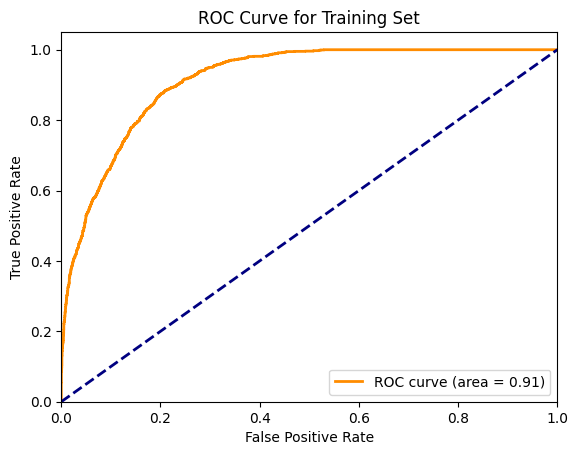

In [21]:
#ROC Curve
y_prob_train = best_rf_classifier.predict_proba(X_train_encoded)[:, 1]

# Compute the ROC curve and AUC score for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_train, pos_label='Yes') 
roc_auc_train = auc(fpr_train, tpr_train)

# Plot the ROC curve for the training set
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Set')
plt.legend(loc='lower right')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec3842c2-c382-455d-93f8-dece0100b701' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>